**Disclaimer:** This code plots various raw COVID-19 data garnered from covidtracking.com. 
As explained there various types of data from several states may have various different caveats,
which may affect the plots here too. 
To quote covidtracking: "Please be aware that each state has its own set of caveats, which we have documented on our data page (https://covidtracking.com/data)."

**Objectives:** My main two objectives were to track testing trends and changes in growth rates
in different states, by looking at raw data or simple fits to them.

(Growth rates are currently found by linear fits on semi-log plots to data from the last 7 days.) 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

plt.style.use('ggplot')

In [2]:
covid_states_url = 'https://covidtracking.com/api/states/daily.csv'

In [3]:
covid_data = pd.read_csv(covid_states_url)

print(*list(covid_data.columns), sep=", ")
covid_data #.head(10)

date, state, positive, negative, pending, hospitalizedCurrently, hospitalizedCumulative, inIcuCurrently, inIcuCumulative, onVentilatorCurrently, onVentilatorCumulative, recovered, hash, dateChecked, death, hospitalized, total, totalTestResults, posNeg, fips, deathIncrease, hospitalizedIncrease, negativeIncrease, positiveIncrease, totalTestResultsIncrease


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200411,AK,257.0,7475.0,NaN,NaN,31.0,NaN,NaN,NaN,...,31.0,7732,7732,7732,2,1.0,3.0,289.0,11.0,300.0
1,20200411,AL,3191.0,18058.0,NaN,NaN,402.0,NaN,NaN,NaN,...,402.0,21249,21249,21249,1,11.0,34.0,0.0,223.0,223.0
2,20200411,AR,1226.0,17352.0,NaN,86.0,130.0,NaN,43.0,33.0,...,130.0,18578,18578,18578,5,1.0,0.0,1403.0,55.0,1458.0
3,20200411,AS,0.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5,3,3,60,0.0,0.0,-17.0,0.0,-17.0
4,20200411,AZ,3393.0,37137.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,40530,40530,40530,4,11.0,0.0,2515.0,281.0,2796.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051,20200302,WA,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34,34,34,53,3.0,0.0,0.0,4.0,4.0
2052,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,44,NaN,NaN,NaN,NaN,NaN
2053,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30,30,30,53,3.0,0.0,0.0,12.0,12.0
2054,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,18,18,53,1.0,0.0,0.0,9.0,9.0


# plotting functions

In [4]:
figsiz0 = np.array(mpl.rcParams["figure.figsize"])

#date_format = '%m/%d'
date_format = '%b %d'

In [5]:
kwargs = {}
kwargs['color'] = 33
kwargs

{'color': 33}

In [6]:
def plot_fit(ax, lag, dates, ydata, color="r", **kwargs):
    x = mpl.dates.datestr2num(dates)[:lag]
    y = ydata.to_numpy()[:lag]
    fit = np.polyfit(x, np.log10(y), 1)
    ax.plot_date(x, 10**np.poly1d(fit)(x),"-", color=color, **kwargs)

    dbl_time = np.log10(2)/fit[0]
    growth = 10**fit[0] - 1
    ax.text(.5, .3, f"Linear fit to past {lag} days:", transform=ax.transAxes, color=color)
    ax.text(.55, .2, f"doubling = {dbl_time:.1f} days", transform=ax.transAxes, color=color)
    ax.text(.55, .1, f"daily growth = {growth:.0%}", transform=ax.transAxes, color=color)

    return fit

def plot_y_vs_dates(ax, dates, ydatas, ylabel, colors=None, labels=None, log_scale=False, ylim=None):
    for i, ydata in enumerate(ydatas): 
        kwargs = {}
        if isinstance(colors, list):
            kwargs['color'] = colors[i]
        if isinstance(labels, list):
            kwargs['label'] = labels[i]
        ax.plot_date(mpl.dates.datestr2num(dates), ydata, **kwargs)

    # rule = mpl.dates.rrulewrapper(YEARLY, byeaster=1, interval=5)
    # loc = mpl.dates.RRuleLocator(rule)
    # ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(date_format))
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.set_ylabel(ylabel)
    if ylim:
        ax.set_ylim(ylim)
    if log_scale:
        if isinstance(log_scale, list):
            ax.set_yscale('log', subsy=log_scale)
        else:
            ax.set_yscale('log')
    if len(ydatas) > 1:
        ax.legend(loc='upper left')
    
def plot_state_data(state, stdata, rowcols, PLOT_TOTAL=False, fit_lag_death=None, fit_lag_pos=None,
                                                              daily_prcnt=True, plot_recovered=False):
    
    dates = stdata.date.to_numpy(dtype=str)
    cmap = plt.get_cmap("tab10")
    tab10 = [cmap(i) for i in range(10)]
    
    figsiz = figsiz0*np.array(rowcols[::-1])*.9
    fig, axs = plt.subplots(*rowcols, figsize=figsiz)
    fig.subplots_adjust(wspace=.3)
        
    title = "Entire US" if len(state)>2 else 'State: '+state
    fig.suptitle(title, y=0.93, fontsize='xx-large')

    ax = axs[0][0]
    if not PLOT_TOTAL:
        plot_y_vs_dates(ax, dates, ydatas=[stdata.positive], ylabel='cum. positives')
    else:
        plot_y_vs_dates(ax, dates, ydatas=[stdata.positive, stdata.positive+stdata.negative],
                            ylabel='cum. counts', labels=['positive', 'tested'])

        
    ax = axs[1][0]
    plot_y_vs_dates(ax, dates, ydatas=[stdata.positive, stdata.positive+stdata.negative],
                        ylabel='cum. counts', labels=['positive', 'tested'], log_scale=True)
    if fit_lag_pos:
        plot_fit(ax, fit_lag_pos, dates, stdata.positive, color="r")


    ax = axs[0][1]
    ydata = 100*stdata.positive/(stdata.positive+stdata.negative)
    plot_y_vs_dates(ax, dates, ydatas=[ydata], ylabel='cum. positives/cum. tested (%)', 
                    colors=[tab10[2]], ylim=[0,max(50, ydata.max()*1.05)])

        
    ax = axs[1][1]
    color = "black"
    plot_y_vs_dates(ax, dates, ydatas=[stdata.death], ylabel='cum. deaths', 
                    colors=["black"], log_scale=True)
    if fit_lag_death:
        plot_fit(ax, fit_lag_death, dates, stdata.death, color=color)

        
    if rowcols[1]==3:
        ax = axs[0][2]
        if not daily_prcnt: 
            ydata = stdata.hospitalizedCurrently
            if not np.isnan(ydata.to_numpy()).all():
                if not np.isnan(np.nanmin(ydata)) and not np.isnan(np.nanmin(ydata)):
                    ylim = [10**(int(np.log10(np.nanmin(ydata)))-.05), np.nanmax(ydata) * 1.2]
                else:
                    ylim = None
                plot_y_vs_dates(ax, dates, ydatas=[ydata], ylabel='hospitalized currently', 
                            colors=[tab10[1]], ylim=ylim, log_scale=[5])
            else:
                ax.remove()
        else:
            ydata = 100*stdata.positiveIncrease/(stdata.positiveIncrease+stdata.negativeIncrease)
            plot_y_vs_dates(ax, dates, ydatas=[ydata], ylabel='daily positives/daily tested (%)', 
                            colors=[tab10[2]], ylim=[0,max(50, ydata.max()*1.05)])
            
        ax = axs[1][2]
        if plot_recovered:
            ydata = stdata.recovered
            if not np.isnan(ydata.to_numpy()).all():
                if not np.isnan(np.nanmin(ydata)) and not np.isnan(np.nanmin(ydata)):
                    ylim = [10**(int(np.log10(np.nanmin(ydata)))-.05), np.nanmax(ydata) * 1.2]
                else:
                    ylim = None
                plot_y_vs_dates(ax, dates, ydatas=[ydata], ylabel='cum. recovered', 
                            colors=[tab10[4]], ylim=ylim, log_scale=[5])
            else:
                ax.remove()
        else:
            plot_y_vs_dates(ax, dates, ydatas=[stdata.positiveIncrease, stdata.positiveIncrease+stdata.negativeIncrease],
                    ylabel='daily counts', labels=['positive', 'tested'])
        
      

# State plots

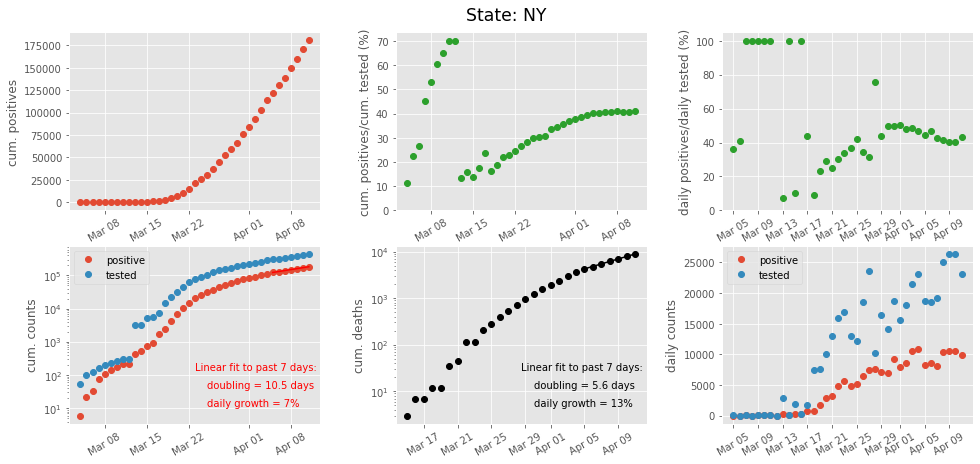

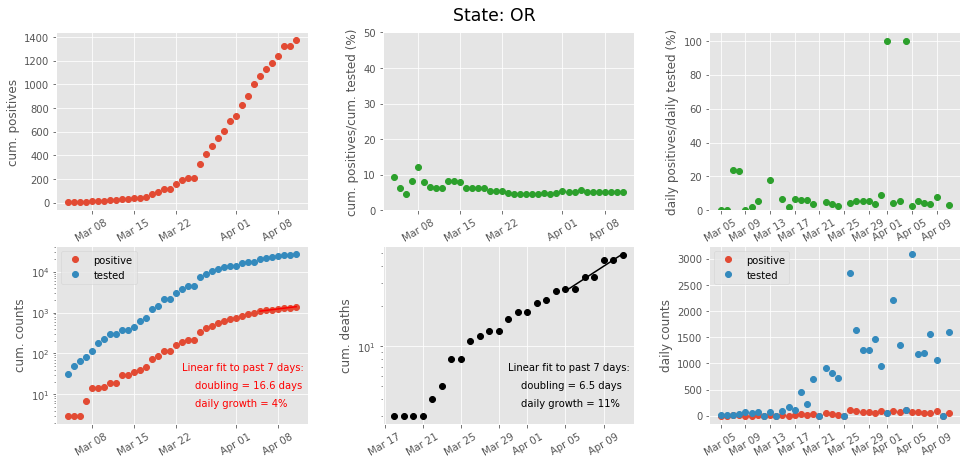

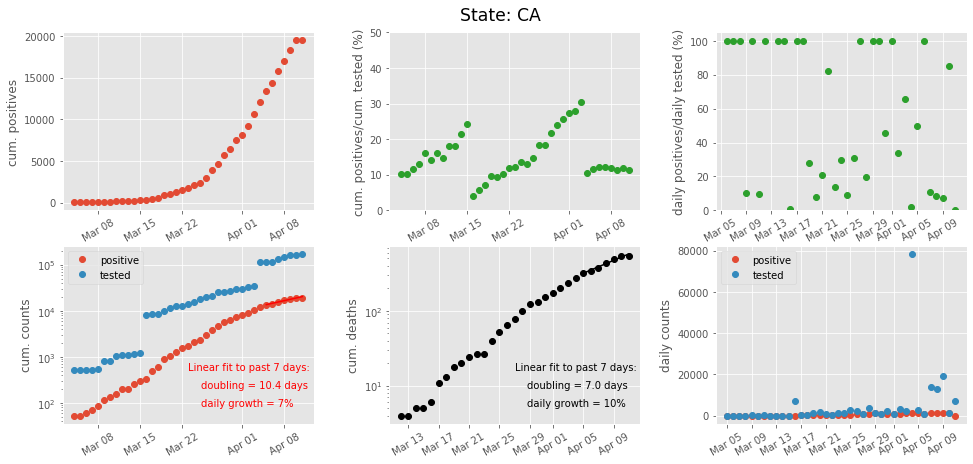

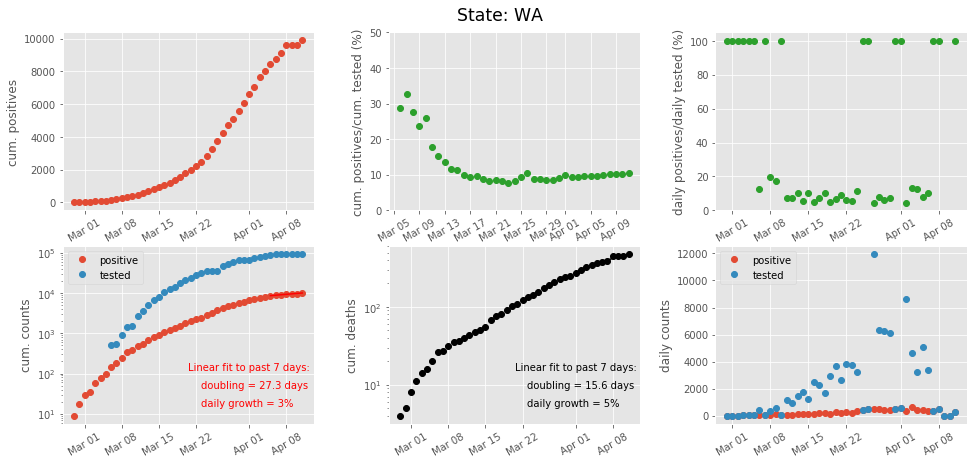

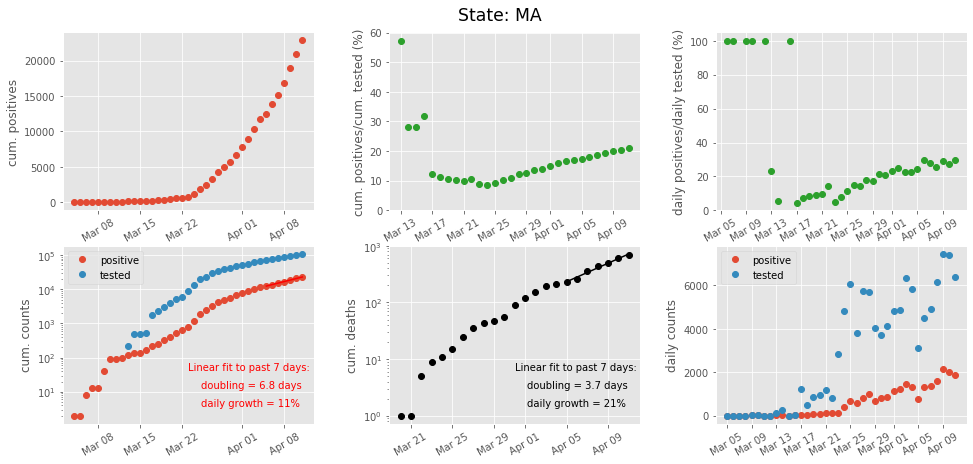

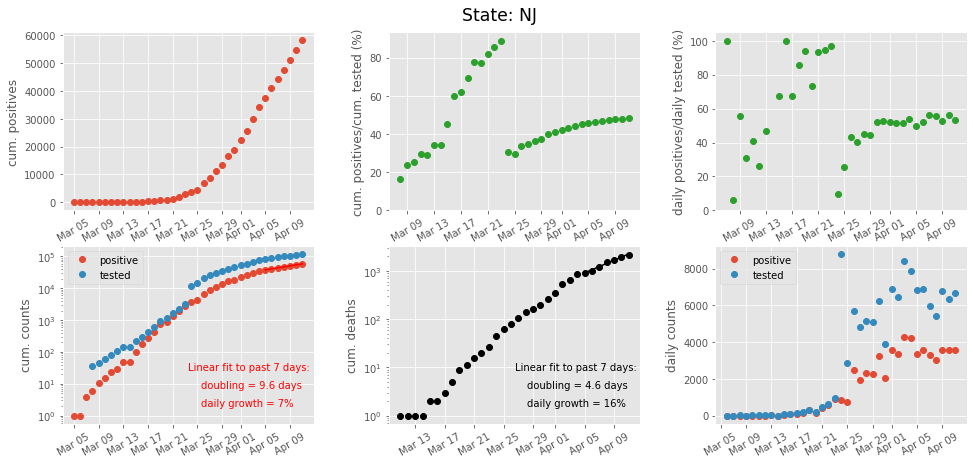

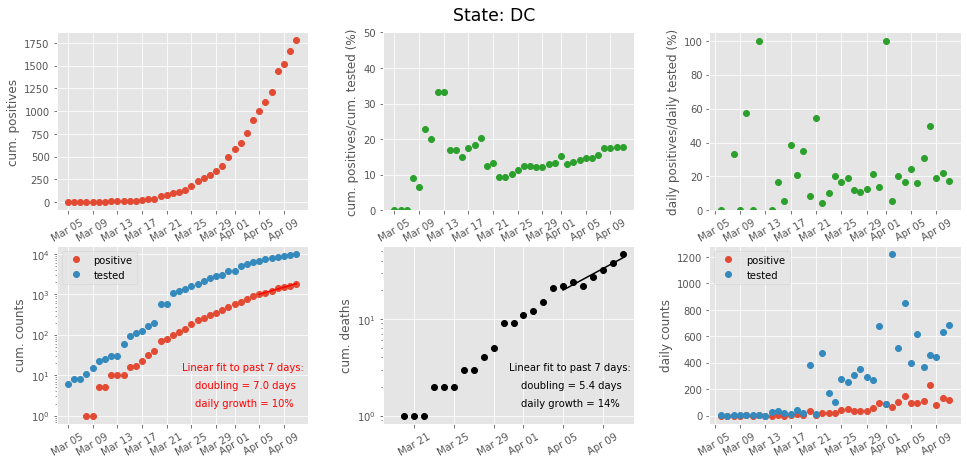

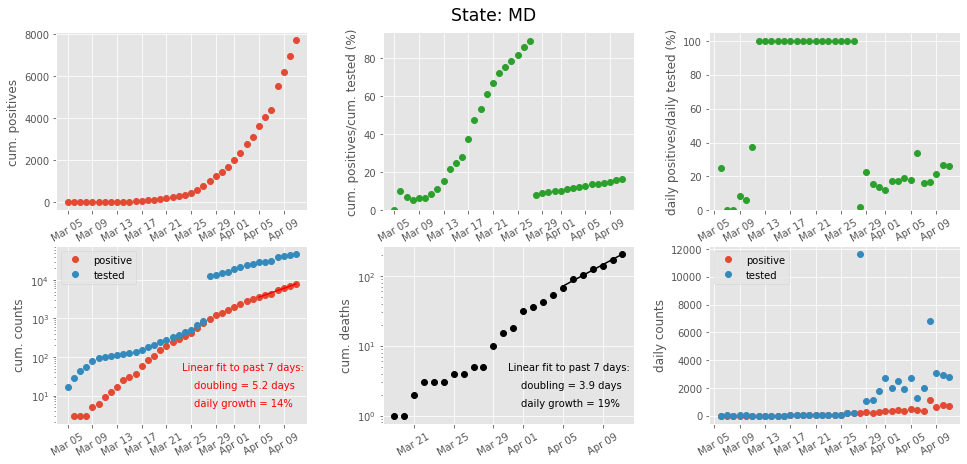

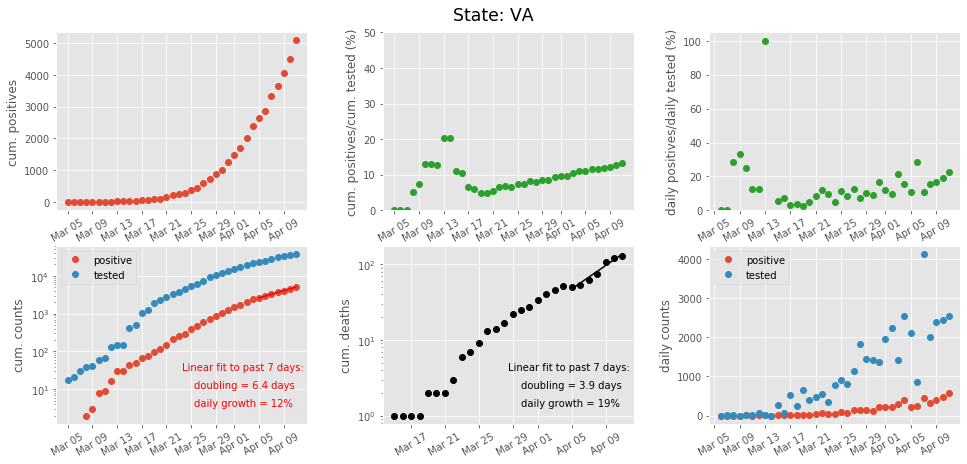

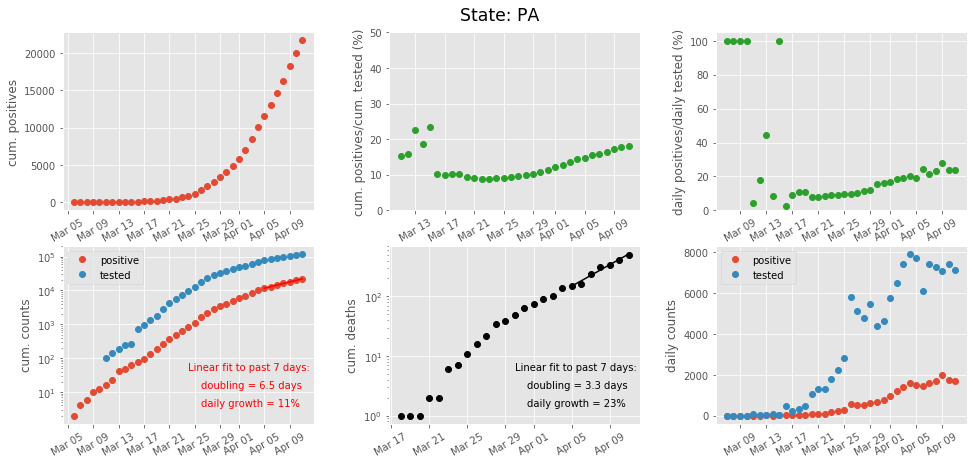

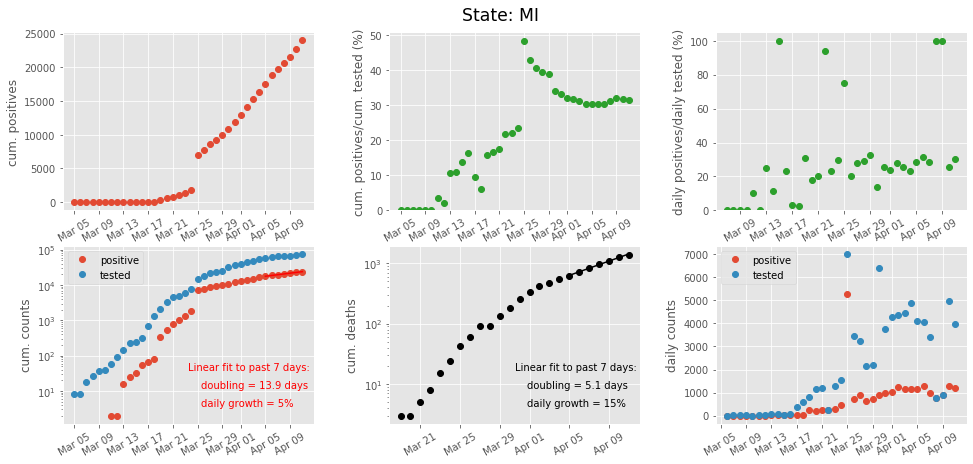

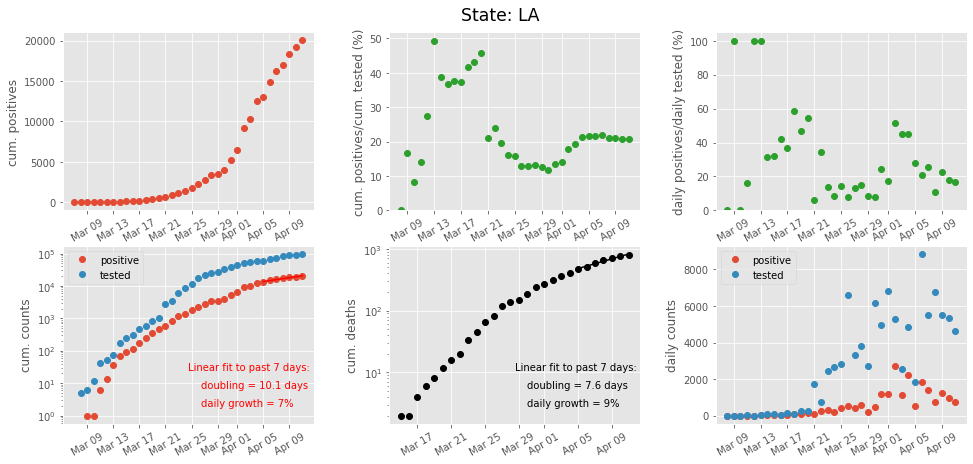

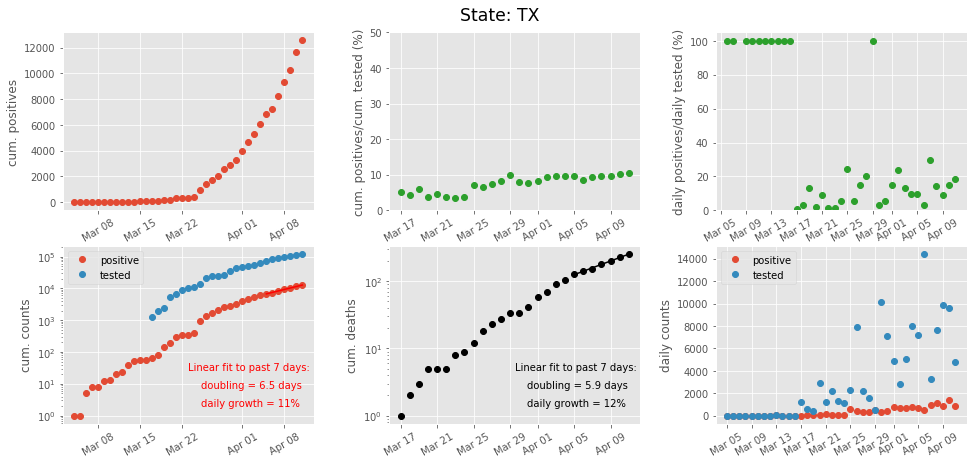

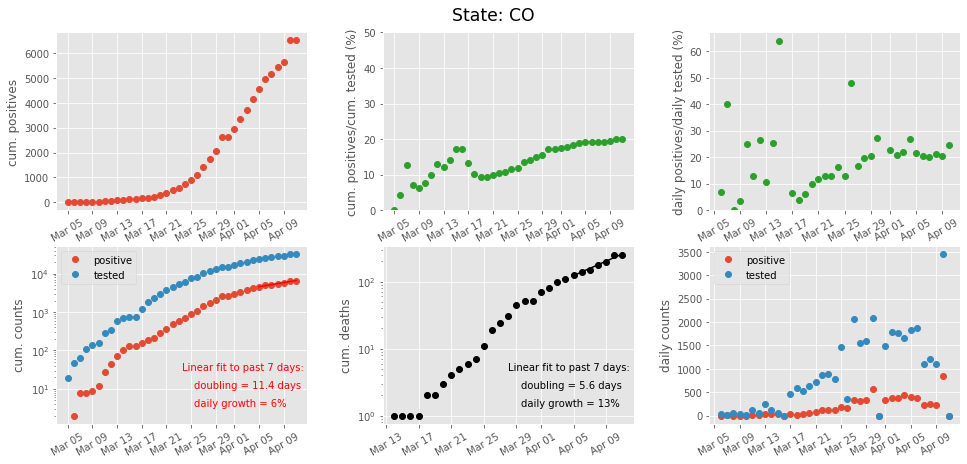

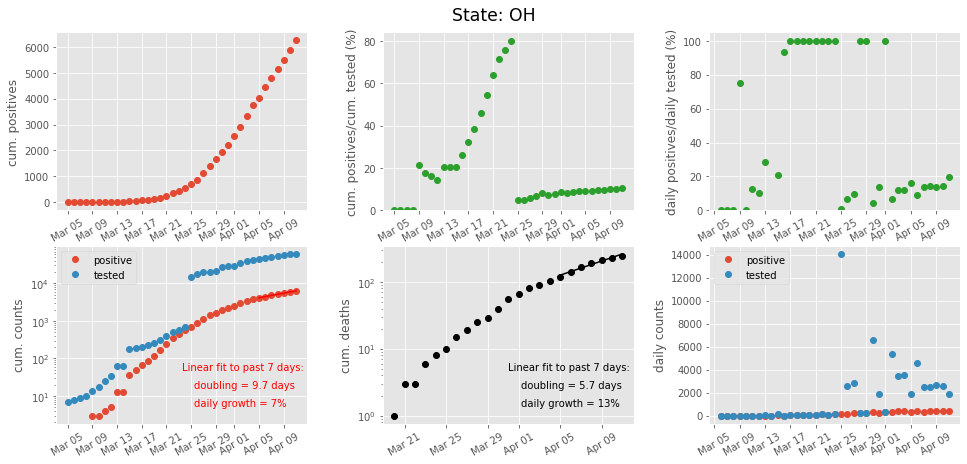

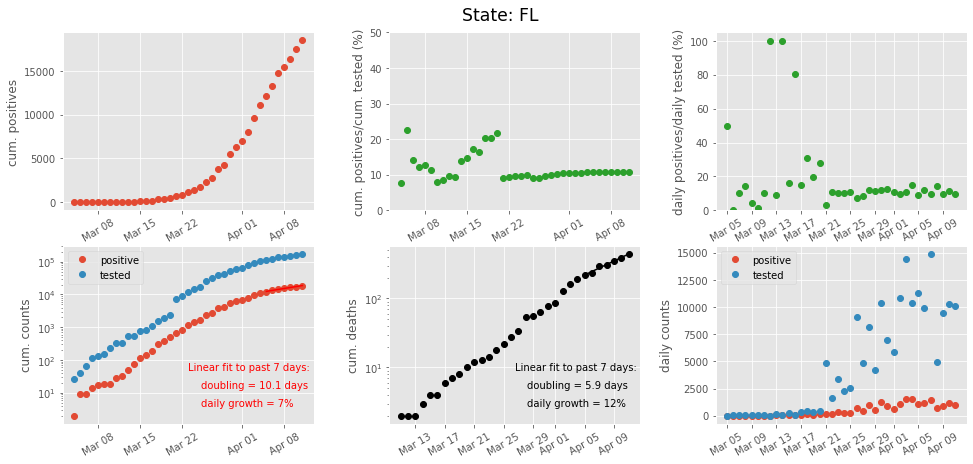

In [11]:
states = ['NY', 'OR', 'CA', 'WA', 'MA', 'NJ', 'DC', 'MD', 'VA', 'PA', 'MI', 'LA', 'TX', 'CO', 'OH','FL']

lag_death = 7
lag_pos = 7
rowcols = (2,3)
for state in states:
    stdata = covid_data[covid_data.state==state]
    plot_state_data(state, stdata, rowcols=rowcols, PLOT_TOTAL=False, fit_lag_death=lag_death, fit_lag_pos=lag_pos)


# Entire US plots

In [12]:
covid_us_url = 'https://covidtracking.com/api/us/daily.csv'

In [13]:
covid_us_data = pd.read_csv(covid_us_url)

print(*list(covid_us_data.columns), sep=", ")

date, states, positive, negative, pending, hospitalizedCurrently, hospitalizedCumulative, inIcuCurrently, inIcuCumulative, onVentilatorCurrently, onVentilatorCumulative, recovered, hash, dateChecked, death, hospitalized, total, totalTestResults, posNeg, deathIncrease, hospitalizedIncrease, negativeIncrease, positiveIncrease, totalTestResultsIncrease


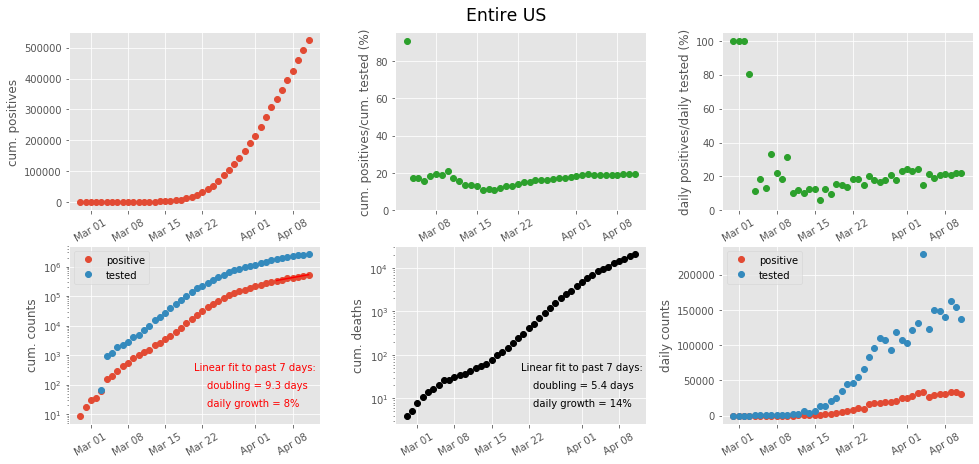

In [14]:
plot_state_data("entire US", covid_us_data, rowcols=rowcols, PLOT_TOTAL=False,
                fit_lag_death=lag_death, fit_lag_pos=lag_pos)